*As I am planning to become a Product Data Analyst I was mostly focusing on product data analysis during my Hyper Island journey. I did sentiment analysis for [Movie reviews](https://www.kaggle.com/tklimonova/sentiment-analysis-of-movie-reviews) (that can be used the same way for product reviews) and [RFM analysis](https://www.kaggle.com/tklimonova/online-retail-cohort-and-rfm-analysis) for customers data.*

*For my personal project I decided to apply my knowledge of A/B tests and learn how to design an experiment for a product and analyse the results to draw some insights and reccomendations.*

### **Website of the grossery store chain**

<img src="https://i.imgur.com/PPBlwBa.png" width="300px">


**In this use case I am working as an analyst for a large grossery chain. One of the goals our company has, it's to drive more customers to download our mobile app and register for the loyalty program.**

*My manager is curious if changing link to a button of the app store will improve the click through rate for our download app page.*

![link to button for downloading the app](https://i.imgur.com/RXxvVpY.png)

In [1]:
#let's import the needed libraries for the analysis
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pymatch.Matcher import Matcher
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

In [2]:
#upload grossery website data
grossery_web_data_orig = pd.read_csv('grocerywebsiteabtestdata.csv')
grossery_web_data_orig.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


**To find the answer I will perform a randomized experiment.**

Our unit of diversion in this experiment is IP address. 
The population we're targeting - Website visitors without an account. 
The duration of the test - 1 week. 
The size of our treatment and control groups - 1/3 of the treatment units and 2/3 of control units.

*Let's try to figure out if the customer clicked or not on the download app button on the home page.*

### Data preparation 

Server 1 will contain the data for our treatment group and servers 2 and 3 for the control group. So data will be divided as 33% and 67%. 

LoggedInFlag (shows if user has profile on our website) and VisitPageFlag (shows if user clicked on our dowlnoad app link).

In [3]:
grossery_web_data = grossery_web_data_orig.groupby(['IP Address', 'LoggedInFlag', 'ServerID'])['VisitPageFlag'].sum().reset_index(name='sum_VisitPageFlag')

In [4]:
grossery_web_data['visitFlag'] = grossery_web_data['sum_VisitPageFlag'].apply(lambda x: 1 if x !=0 else 0)
grossery_web_data.head()

,IP Address,LoggedInFlag,ServerID,sum_VisitPageFlag,visitFlag
0,0.0.108.2,0,1,0,0
1,0.0.109.6,1,1,0,0
2,0.0.111.8,0,3,0,0
3,0.0.160.9,1,2,0,0
4,0.0.163.1,0,2,0,0


In [5]:
#creating groups for control and treatment
grossery_web_data['group'] = grossery_web_data.ServerID.map({1:'Treatment', 2:'Control', 3:'Control'})

In [6]:
grossery_web_data.dtypes

IP Address           object
LoggedInFlag          int64
ServerID              int64
sum_VisitPageFlag     int64
visitFlag             int64
group                object
dtype: object

In [7]:
#removing all records where the LoggedInFlag=1, so it filters out all the users with accounts
grossery_web_data = grossery_web_data[grossery_web_data['LoggedInFlag'] != 1]
grossery_web_data.head()

,IP Address,LoggedInFlag,ServerID,sum_VisitPageFlag,visitFlag,group
0,0.0.108.2,0,1,0,0,Treatment
2,0.0.111.8,0,3,0,0,Control
4,0.0.163.1,0,2,0,0,Control
7,0.0.181.9,0,1,1,1,Treatment
11,0.0.20.3,0,1,0,0,Treatment


### Analyzing the result

In [8]:
treatment = grossery_web_data[grossery_web_data['group']=='Treatment']
control = grossery_web_data[grossery_web_data['group']=='Control']

ttest_ind(treatment['visitFlag'], control['visitFlag'], equal_var = False)

Ttest_indResult(statistic=11.879472502167134, pvalue=1.781696815610413e-32)

Looking at the result of p-value seems like it's unlikely that means are the same.

So next let's count number of visits grouped by treatment or control group and see if they clicked on a link.

In [9]:
#let's calculate the differences in means
grossery_web_data_diff_mean = grossery_web_data.groupby(['visitFlag', 'group'])['visitFlag'].count().reset_index(name='Count')
grossery_web_data_diff_mean

,visitFlag,group,Count
0,0,Control,26839
1,0,Treatment,12696
2,1,Control,6131
3,1,Treatment,3847


It would be nice to see the percent differences.

In [10]:
#crosstab by groups
groupped = pd.crosstab(grossery_web_data_diff_mean['group'], grossery_web_data_diff_mean['visitFlag'], values=grossery_web_data_diff_mean['Count'], aggfunc=np.sum, margins=True)
groupped

visitFlag,0,1,All
group,,,
Control,26839,6131,32970
Treatment,12696,3847,16543
All,39535,9978,49513


In [11]:
#Percentage row
100*groupped.div(groupped['All'], axis=0)

visitFlag,0,1,All
group,,,
Control,81.404307,18.595693,100.0
Treatment,76.745451,23.254549,100.0
All,79.847717,20.152283,100.0


In the Control group percentage of users that clicked on the link is ~19% and in the treatment group ~23%, so 4% jump.

**The result of our AB test shows that the company can drive approximately 4% more users to click on the app download if they change the link for the App store / Play store button.**

----------------------------------------

### Matched Pair Design Test

**In this use case I am trying to introduce a new product (grape flavoured candy) and determine the potential sales change if the product is introduced.**

<img src="https://partycity6.scene7.com/is/image/PartyCity/_pdp_sq_?$_1000x1000_$&$product=PartyCity/319893" width="200px">

In [12]:
#New product control data
control_df = pd.read_csv('newproductcontroldata.csv')
control_df.head()

,Store ID,City,State,Zip Code,Category Sales,Product Count,Size
0,1,ALABASTER,AL,35007,18.88,1,Large
1,2,BIRMINGHAM,AL,35209,44125.66,6,Large
2,3,DECATUR,AL,35601,46627.92,5,Large
3,4,HUNTSVILLE,AL,35806,26658.48,6,Large
4,5,MOBILE,AL,36606,1863.60,3,Large


In [13]:
control_df.columns = [
    "Store_ID",
    "City",
    "State",
    "Zip_Code",
    "Category_Sales",
    "Product_Count",
    "Size"
]

In [14]:
control_df.isnull().sum()

Store_ID          0
City              0
State             0
Zip_Code          0
Category_Sales    0
Product_Count     0
Size              0
dtype: int64

In [15]:
#to make sure all fields, that are needed for calculations have numerical data types
control_df.dtypes

Store_ID            int64
City               object
State              object
Zip_Code            int64
Category_Sales    float64
Product_Count       int64
Size               object
dtype: object

**I will use a Match pair design for this experiment as the volume of our users is pretty low, and I want to reduce the chance of accidental bias to be more confident in the result.**

*First, I want to figure out what will be my Treatment (experimental) and Control variables. As we would measure Sales, 'Category_Sales' will be our Experimental variable.*

*Let's test if there is a relationship between Sales and Product Count, as well as between Sales and Size of the store.*

In [16]:
# correlation between Product Count and Category Sales
control_df['Product_Count'].corr(control_df['Category_Sales'])

0.4318812952414523

So Product Count will be included in the experiment since sale is related to the products sold in the store.  

*Let's look at a relationship between store size and Sales*

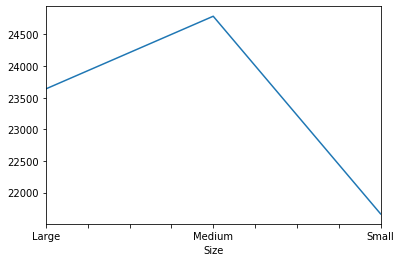

In [17]:
# as Size is a categorical variable I would need to use plot of means 

avg_sales = control_df.groupby('Size')['Category_Sales'].agg('mean')
avg_sales.plot()
plt.show()

If there is a correlation between Size and Sales, the plot would have more linear relationship. So there is no pattern that correlates with store size and sale which means that size is not a valid control variable and I will not use it.

*Let's check if there are enough stores by each State and City*

In [18]:
control_df.groupby(['State', 'City'])['Store_ID'].count().to_frame().reset_index().sort_values('Store_ID', ascending = False).head(10).set_index('State')

,City,Store_ID
State,,
IL,Chicago,63
NY,New York,54
TX,San Antonio,52
TX,Houston,49
CA,San Diego,32
TX,Dallas,31
CA,Los Angeles,28
FL,Orlando,28
FL,Miami,28


As it's too few Stores in each State/City combination. Let's just look at only State.

In [19]:
control_df.groupby(['State'])['Store_ID'].count().to_frame().reset_index().sort_values('Store_ID', ascending = False).head(10).set_index('State')

,Store_ID
State,
CA,913
TX,574
FL,490
IL,337
NC,263
VA,242
OH,228
GA,225
NY,212


It's much more stores per state, so it will be our second control variable.

***Control variables for this experiment are Product Count and State as they both correlate for Category Sales, which is my target variable***

*For this experiment I have Control data in control_df and I will import treatment data in grape_stores dataframe.*

*Treatment units* are the stores where will introduce our new product (new flavour of candies). 
*Control group* (control units) are the stores which will be the baseline of the treatment group, so control units don't have our new product.

H0 (null hypothesis): "*New flavour of candies have no effect on sales in the store.*"

HA (alternative hypothesis): "*New flavor of candies will increase sales in the store.*"

In [20]:
#a set of 10 treatment stores in California where the Grape flavor of the product will be sold
grape_stores = pd.read_csv('grapeproducttreatmentstores.csv')
grape_stores

,Store ID,City,State,Zip Code,Category Sales,Product Count,Size
0,332,La Mesa,CA,91942,56792.96,5,Large
1,944,Palmdale,CA,93551,41.50,1,Large
2,1181,Lake Elsinore,CA,92532,1514.11,4,Large
3,2696,Redondo Beach,CA,90278,2006.88,4,Large
4,2717,Thousand Oaks,CA,91320,80.04,2,Large
5,3060,San Francisco,CA,94111,26467.99,7,Large
6,5019,Napa,CA,94558,16744.96,5,Large
7,5051,Simi Valley,CA,93065,1378.85,3,Large
8,5395,Los Angeles,CA,90079,5669.56,5,Large
9,5834,Fremont,CA,94539,19064.48,6,Large


In [21]:
#let's limit control stores to only California, as our treatment stores data are only from CA
control_stores_CA = control_df[control_df.State == 'CA']
control_stores_CA.head(15)

,Store_ID,City,State,Zip_Code,Category_Sales,Product_Count,Size
103,104,Bakersfield,CA,93311,666.18,5,Large
104,105,Canoga Park,CA,91303,868.80,3,Large
105,106,Colma,CA,94014,11682.08,5,Large
106,107,Costa Mesa,CA,92626,58509.72,5,Large
107,108,Dublin,CA,94568,4601.87,4,Large
108,109,Emeryville,CA,94608,4013.40,5,Large
109,110,Glendale,CA,91210,4516.80,5,Large
110,111,Irvine,CA,92618,9556.14,5,Large
111,112,Laguna Niguel,CA,92677,2692.66,6,Large
112,113,Los Angeles,CA,90064,101.18,3,Large


In [22]:
grape_stores.columns = [
    "Store_ID",
    "City",
    "State",
    "Zip_Code",
    "Category_Sales",
    "Product_Count",
    "Size"
]

In [23]:
test_stores = grape_stores['Store_ID'].tolist()

In [24]:
test = grape_stores
control = control_stores_CA
control = control[~control.Store_ID.isin(test_stores)]

In [25]:
#adding column before joining dataset
test['group'] = 1
control['group'] = 0

It took me long time to figure out how to match treatment and control stores using python. So I find out that Causal Inference is the right way to do this and pymatch library helped me with this.

In [28]:
m = Matcher(control, test, yvar="group", exclude=['Store_ID', 'City', 'State', 'Zip_Code', 'Size'])

Formula:
group ~ Category_Sales+Product_Count
n majority: 903
n minority: 10


There is a significant Class Imbalance in our data — the majority group (control stores) having many more records than the minority group (grape stores). We account for this by setting *balance=True* when calling *Matcher.fit_scores()*

In [29]:
np.random.seed(42)
m.fit_scores(balance=True, nmodels=10)

Fitting Models on Balanced Samples: 10\10
Average Accuracy: 62.0%


In [30]:
m.predict_scores()

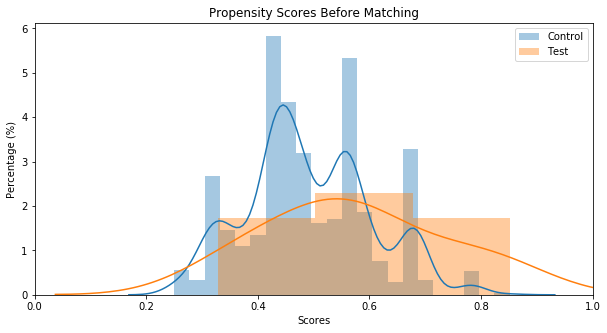

In [31]:
m.plot_scores()

In [32]:
m.match(method="min", nmatches=2, threshold=0)
m.record_frequency()

,freq,n_records
0,1,30


In [33]:
m.assign_weight_vector()

In [34]:
m.matched_data.sort_values("match_id")

,record_id,weight,Store_ID,City,State,Zip_Code,Category_Sales,Product_Count,Size,group,scores,match_id
16,601,1.0,3956,North Highlands,CA,95660,57243.36,5,Medium,0,0.595474,0
12,487,1.0,3058,San Francisco,CA,94111,6167.74,4,Medium,0,0.595611,0
20,903,1.0,332,La Mesa,CA,91942,56792.96,5,Large,1,0.595070,0
21,904,1.0,944,Palmdale,CA,93551,41.50,1,Large,1,0.851490,1
1,38,1.0,315,Carson,CA,90746,293.50,2,Large,0,0.782508,1
4,93,1.0,371,San Jose,CA,95123,27.44,1,Large,0,0.851453,1
17,616,1.0,4786,National City,CA,91950,1526.40,4,Large,0,0.559084,2
22,905,1.0,1181,Lake Elsinore,CA,92532,1514.11,4,Large,1,0.558993,2
9,356,1.0,2665,Fresno,CA,93720,1516.13,4,Large,0,0.559008,2
19,880,1.0,6273,Pico Rivera,CA,90660,2023.36,4,Large,0,0.562809,3


Now everything is set for the execution of the experiment. Our experiment is run for 1 month.

In [35]:
match_pair_pairs_df = pd.read_excel('MatchedPairAnalysis.xlsx', sheet_name='Pairs')

In [36]:
match_pair_data_df = pd.read_excel('MatchedPairAnalysis.xlsx', sheet_name='Data')

In [37]:
match_pair_treat_df = pd.read_excel('MatchedPairAnalysis.xlsx', sheet_name='Treatments')

In [38]:
#add column to differentiate comparable and test periods
from pandas import Timestamp
match_pair_data_df['Period'] = match_pair_data_df['Week_Ending'].apply(lambda x: 'Test' if x >= Timestamp('2011-10-15') else 'Comp')
match_pair_data_df.head()

,Right_Store_ID,Week_Ending,Spend_Cust,NumCustomers,Sum_Gross_Sales,Period
0,1370,2010-01-02,3.28,300,984.00,Comp
1,1370,2010-01-09,3.31,317,1049.27,Comp
2,1370,2010-01-16,3.14,294,923.16,Comp
3,1370,2010-01-23,2.96,353,1044.88,Comp
4,1370,2010-01-30,3.26,347,1131.22,Comp


In [39]:
#average gross sales for comp period
match_pair_data_df ['Avg_gross_sales_p_period'] = match_pair_data_df.groupby(['Right_Store_ID', 'Period'])['Sum_Gross_Sales'].transform('mean')

In [40]:
#growth sales grow
match_pair_data_df['Gross_sales_grow'] = ((match_pair_data_df['Sum_Gross_Sales'] - match_pair_data_df['Avg_gross_sales_p_period'])/match_pair_data_df['Avg_gross_sales_p_period'])*100
match_pair_data_df.head()

,Right_Store_ID,Week_Ending,Spend_Cust,NumCustomers,Sum_Gross_Sales,Period,Avg_gross_sales_p_period,Gross_sales_grow
0,1370,2010-01-02,3.28,300,984.00,Comp,972.194731,1.214291
1,1370,2010-01-09,3.31,317,1049.27,Comp,972.194731,7.927966
2,1370,2010-01-16,3.14,294,923.16,Comp,972.194731,-5.043715
3,1370,2010-01-23,2.96,353,1044.88,Comp,972.194731,7.476410
4,1370,2010-01-30,3.26,347,1131.22,Comp,972.194731,16.357347


In [41]:
#Average the Gross Sales Growth for Test period and Comp period
avg_sales_growth_p_per = pd.pivot_table(match_pair_data_df,index=["Right_Store_ID"],values=["Gross_sales_grow"],columns=["Period"],aggfunc=[np.mean])
avg_sales_growth_p_per = pd.DataFrame(avg_sales_growth_p_per.to_records())
avg_sales_growth_p_per.columns = ['Right_Store_ID', 'Avg_gross_sales_grow_comp', 'Avg_gross_sales_grow_test']
avg_sales_growth_p_per.head()


,Right_Store_ID,Avg_gross_sales_grow_comp,Avg_gross_sales_grow_test
0,313,1.268281e-14,1.930823e-14
1,315,1.258730e-14,-5.097372e-15
2,331,6.490388e-14,2.359465e-14
3,332,7.181830e-15,2.780385e-15
4,360,8.098659e-15,-3.938878e-15


In [42]:
#let's list each store with the appropriate treatment pairing (list of stores for significance testing)
import math
match_pair_treat_df.columns = ['Controls']
list_of_stores_df = pd.merge(left=match_pair_pairs_df, right=match_pair_treat_df, left_on='Controls', right_on='Controls', how='outer')
list_of_stores_df ['Type'] = list_of_stores_df['Treatments'].apply(lambda x: 'Treatment' if math.isnan(x) else 'Control')
list_of_stores_df['Control_Treatment_Pairing'] = list_of_stores_df['Controls'].astype(str)+ '<->' + list_of_stores_df['Treatments'].astype(str)
list_of_stores_df.head()

,Controls,Treatments,Type,Control_Treatment_Pairing
0,3956,332.0,Control,3956<->332.0
1,3058,332.0,Control,3058<->332.0
2,315,944.0,Control,315<->944.0
3,371,944.0,Control,371<->944.0
4,4786,1181.0,Control,4786<->1181.0


In [43]:
#Lookup Average Growth for Test and Comparative period
match_pair_df_final = pd.merge(left=list_of_stores_df, right=avg_sales_growth_p_per, left_on='Controls', right_on='Right_Store_ID', how='right')
match_pair_df_final.head()

,Controls,Treatments,Type,Control_Treatment_Pairing,Right_Store_ID,Avg_gross_sales_grow_comp,Avg_gross_sales_grow_test
0,3956,332.0,Control,3956<->332.0,3956,4.133372e-14,9.074866e-16
1,3058,332.0,Control,3058<->332.0,3058,5.000540e-14,1.266620e-14
2,315,944.0,Control,315<->944.0,315,1.258730e-14,-5.097372e-15
3,371,944.0,Control,371<->944.0,371,-3.117220e-14,1.301374e-14
4,4786,1181.0,Control,4786<->1181.0,4786,3.411369e-14,1.853590e-14


In [44]:
#let's calculate Difference and Test for Significance
match_pair_df_final['Growth_Difference'] = match_pair_df_final['Avg_gross_sales_grow_test'] - match_pair_df_final['Avg_gross_sales_grow_comp']
match_pair_df_final.head()

,Controls,Treatments,Type,Control_Treatment_Pairing,Right_Store_ID,Avg_gross_sales_grow_comp,Avg_gross_sales_grow_test,Growth_Difference
0,3956,332.0,Control,3956<->332.0,3956,4.133372e-14,9.074866e-16,-4.042624e-14
1,3058,332.0,Control,3058<->332.0,3058,5.000540e-14,1.266620e-14,-3.733920e-14
2,315,944.0,Control,315<->944.0,315,1.258730e-14,-5.097372e-15,-1.768467e-14
3,371,944.0,Control,371<->944.0,371,-3.117220e-14,1.301374e-14,4.418594e-14
4,4786,1181.0,Control,4786<->1181.0,4786,3.411369e-14,1.853590e-14,-1.557779e-14


In [45]:
#t-test and significance level
control_mp = match_pair_df_final[match_pair_df_final['Type']=='Control']
treatment_mp = match_pair_df_final[match_pair_df_final['Type']=='Treatment']
ttest_ind(control_mp['Growth_Difference'], treatment_mp['Growth_Difference'], equal_var = False)

Ttest_indResult(statistic=-0.36669685510766936, pvalue=0.717768426475742)

The p-value is not significant, and indicates weak evidence against the null hypothesis.

In [46]:
mapping_c = dict(control_mp[['Controls', 'Growth_Difference']].values)
match_pair_pairs_df['Growth_Difference_cont'] = control_mp.Controls.map(mapping_c)
mapping_t = dict(treatment_mp[['Controls', 'Growth_Difference']].values)
match_pair_pairs_df['Growth_Difference_treat'] = treatment_mp.Treatments.map(mapping_t)

In [47]:
lift_df = match_pair_pairs_df.Treatments.replace(treatment_mp.set_index('Controls')['Growth_Difference'])
match_pair_pairs_df['Growth_Difference_treat'] = lift_df
match_pair_pairs_df

,Controls,Treatments,Growth_Difference_cont,Growth_Difference_treat
0,3956,332,-4.042624e-14,-4.401445e-15
1,3058,332,-3.733920e-14,-4.401445e-15
2,315,944,-1.768467e-14,2.383590e-14
3,371,944,4.418594e-14,2.383590e-14
4,4786,1181,-1.557779e-14,-2.030644e-14
5,2665,1181,1.276523e-15,-2.030644e-14
6,6273,2696,2.579517e-14,7.842877e-15
7,313,2696,6.625421e-15,7.842877e-15
8,5057,2717,-4.595441e-14,-4.858926e-14
9,331,2717,-4.130922e-14,-4.858926e-14


In [48]:
#calculating the lift
match_pair_pairs_df['lift'] = ((match_pair_pairs_df['Growth_Difference_treat'] - match_pair_pairs_df['Growth_Difference_cont']) / (1 + match_pair_pairs_df['Growth_Difference_cont']))
match_pair_pairs_df.head()

,Controls,Treatments,Growth_Difference_cont,Growth_Difference_treat,lift
0,3956,332,-4.042624e-14,-4.401445e-15,3.602479e-14
1,3058,332,-3.733920e-14,-4.401445e-15,3.293776e-14
2,315,944,-1.768467e-14,2.383590e-14,4.152058e-14
3,371,944,4.418594e-14,2.383590e-14,-2.035004e-14
4,4786,1181,-1.557779e-14,-2.030644e-14,-4.728647e-15


In [49]:
#average lift
average_lift = (match_pair_pairs_df['lift'].mean())*100
print ('Average lift:{}%'.format(average_lift))

Average lift:4.000245843020712e-13%


Lift shows us that an average customer spend per week in a treatment store increased by 4% during the experiment.

As our Match Pair design experiment had really small sample of treatment stores and experiment is run for only one month, my AB test results were not significant and I can't tell with confidence that introducing new product will increase sales visibly.